# Introdução ao Keras

Texto adaptado de: https://towardsdatascience.com/introduction-to-deep-learning-with-keras-17c09e4f0eb2.

Keras é uma API de redes neurais de alto nível, capaz de rodar em cima do Tensorflow, Thano e CNTK. 

## Modelos

A estrutura fundamental do Keras são os modelos, forma de organizar camadas de redes neurais. O modelo mais simples é o Sequential, com camadas lineares. Neste exemplo estarei utilizando o modelo Sequential com o dataset MNIST, um base de 7000 imagens em escala de cinza 28 x 28 com 10 classes diferentes. Keras dividirá o data set em 6000 instancias de treinamento e 1000 de testes.

In [0]:
from keras.datasets import mnist # import mnist dataset

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [0]:
(o_x_train, o_y_train), (o_x_test, o_y_test) = mnist.load_data()

In [0]:
print('Treinamento: %d. Teste: %d ' % (len(y_train), len(y_test)))

Treinamento: 60000. Teste: 10000 


Para alimentar uma rede neural convolucional nós transformamos o datafram para 4 dimensões. Isto pode ser feito usando numpy `reshape`. Também vamos transformar dados em `float` e normaliza-los.

In [0]:
x_train.shape

(60000, 28, 28)

In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [0]:
x_train.shape

(60000, 28, 28, 1)

Também mudaremos nossos rótulos para [one-hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f) usando `to_categorical`, método do Keras.

In [0]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [0]:
from keras.utils import to_categorical

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [0]:
y_train[1]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

## Criando o modelo

Abaixo será criado o modelo de treinamento para o MNIST. É interessante conhecer todos estes conceitos de pooling, convolução... e todas as camadas utilizadas abaixo. [Este tutorial](http://cs231n.github.io/convolutional-networks/) é um bom material para estudo de tais conceitos.

In [0]:
x_train.shape

(60000, 28, 28, 1)

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

In [0]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=x_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(10, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Antes de começar o treinamento do nosso modelo precisamos configurar o processo de aprendizado. Para isto, precisaremos especificar um **otimizador**, uma **função de perda** e, opcionalmente, algumas métricas de acuracia.

A função de perda ([loss function](https://www.youtube.com/watch?v=IVVVjBSk9N0)) é a medida de quão bom nosso modelo está ao atingir o objetivo dado.

O [otimizador](https://towardsdatascience.com/types-of-optimization-algorithms-used-in-neural-networks-and-ways-to-optimize-gradient-95ae5d39529f) é usado para minimizar a função de perda (objetivo) atualizando os pesos usando os gradientes.

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Aumentando os dados de imagem

Augmentation é o processo de criar mais dados de um existente. Para imagens você pode adicionar algumas transformações como rotacionar a imagem, dar zoom, adicionar ruído e muitas outras.

Isto ajuda a tornar o modelo mais robusto e resolver problemas de não possuir dados suficientes. Keras tem um metodo chamado `ImageDataGenerator` que pode ser usado para aumentar imagens.

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=10, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1)

Este data generator criará novas imagens que podem ser rotacionadas, aproximadas ou deslocadas para cima ou para baixo.

## Treinar o modelo

Agora que definimos e compilamos nosso modelo, ele está pronto para o treinamento. Normalmente utilizariamos o método `fit` para fazer o treinamento, mas como estamos utilizando um datagenerator nós usaremos o `fit_generator` e passaremos nosso gerador, entradas de treinamento, saidas assim como o número de [epochs e batch](https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9). Também vamos passar um conjunto de validação para que possamos monitorar a perda e acurácia em ambos os conjuntos conforme steps_per_epoch que é requerida quando utilizamos o gerator que é apenas o tamanho do conjunto de treinamento dividido pelo batch_size.

In [0]:
epochs = 3
batch_size = 32
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=epochs,
                             validation_data=(x_test, y_test), steps_per_epoch=x_train.shape[0]//batch_size)

Instructions for updating:
Use tf.cast instead.
Epoch 1/3
1875/1875 [==============================] - 260s 139ms/step - loss: 0.3387 - acc: 0.8937 - val_loss: 0.0394 - val_acc: 0.9870
Epoch 2/3
1875/1875 [==============================] - 258s 138ms/step - loss: 0.1166 - acc: 0.9658 - val_loss: 0.0223 - val_acc: 0.9928
Epoch 3/3
1875/1875 [==============================] - 257s 137ms/step - loss: 0.0919 - acc: 0.9739 - val_loss: 0.0267 - val_acc: 0.9916


In [0]:
model.save_weights("model.h5")

In [0]:
x_train[:1].shape

(1, 28, 28, 1)

In [0]:
model.predict_classes(x_train[:5])

array([5, 0, 4, 1, 9])

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

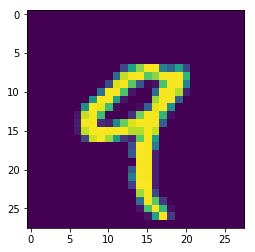

In [0]:
imgplot = plt.imshow(o_x_train[4])

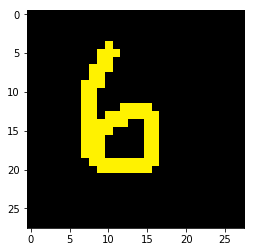

In [0]:
my_six = mpimg.imread('six.png')
plt.imshow(my_six)

In [0]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [0]:
my_six_rgb = rgb2gray(my_six)
my_six_rgb.shape

my_six_rgb = my_six_rgb.reshape(1, 28, 28, 1)

model.predict_classes([my_six_rgb])

array([6])